## 상권 분석 및 폐업률 예측

### 0. License 설명

Copyright 2019 The TensorFlow Author

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

https://www.tensorflow.org/tutorials/structured_data/time_series

### 1. 데이터 불러오기

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import math

mpl.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Malgun Gothic'

데이터셋 설명
- 상권분석에는 서울시 공공데이터 포털사이트에서 다운받은 상권 데이터셋을 사용함
- 직장인구, 집객시설 수 등 8가지 변수가 포함되어 있음
- 2015년 1분기~2020년 2분기까지 총 22개의 분기동안 수집된 데이터 사용
- 총 상권의 갯수는 1496개(원핫임베딩 되어있음)
- 8가지 변수 모두에 대해 결측치를 조사한 결과, 년도와 분기별로 몇몇 상권이 빠져있음을 확인했음. 결측치는 KNNImputer를 활용해 값을 채워넣음
- 상권별 자치구 label 포함

In [2]:
data=pd.read_csv("KNN_LABEL_CODE_NAME.csv",encoding="cp949")
data

,Unnamed: 0,Unnamed: 0.1,기준_년_코드,기준_분기_코드,상권코드_0,상권코드_1,상권코드_2,상권코드_3,상권코드_4,상권코드_5,...,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률,상권_코드,시군구_코드,자치구_명
0,0,0,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.273333,2.942853e+08,24.0,52.000000,1.671959e+11,15904.000000,2.587177,1001496,11680,강남구
1,1,1,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.000000,5.273471e+08,8221.0,242.000000,1.546181e+11,24375.000000,3.026257,1001495,11710,송파구
2,2,2,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.000000,1.120979e+08,1924.0,327.000000,2.592398e+11,32935.000000,2.081362,1001494,11110,종로구
3,3,3,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53.000000,2.379674e+08,2427.0,165.000000,2.466393e+11,6054.000000,2.107308,1001493,11140,중구
4,4,4,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.273333,2.942853e+08,1104.0,593.000000,3.766214e+11,104830.000000,2.163080,1001492,11140,중구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32907,32907,32907,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.000000,7.108571e+07,108.0,37.766667,8.661690e+08,488.026667,5.555556,1001443,11590,동작구
32908,32908,32908,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.273333,2.942853e+08,15.0,2.000000,2.782282e+09,435.340000,0.000000,1001456,11620,관악구
32909,32909,32909,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.273333,2.942853e+08,162.0,2.000000,4.617167e+09,440.340000,1.492537,1001464,11620,관악구
32910,32910,32910,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.273333,2.942853e+08,52.0,2.000000,2.625743e+09,438.653333,0.000000,1001465,11620,관악구


In [3]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', '기준_년_코드', '기준_분기_코드', '상권코드_0', '상권코드_1',
       '상권코드_2', '상권코드_3', '상권코드_4', '상권코드_5',
       ...
       '아파트_평균_면적', '아파트_평균_시가', '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수',
       '폐업률', '상권_코드', '시군구_코드', '자치구_명'],
      dtype='object', length=1512)

In [4]:
data=data[['기준_년_코드', '기준_분기_코드', '총_유동인구_수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가',
       '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수', '폐업률', '상권_코드', '시군구_코드']]
data

,기준_년_코드,기준_분기_코드,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률,상권_코드,시군구_코드
0,2020.0,2.0,90544.0,14.48,82.273333,2.942853e+08,24.0,52.000000,1.671959e+11,15904.000000,2.587177,1001496,11680
1,2020.0,2.0,3026454.0,22.00,89.000000,5.273471e+08,8221.0,242.000000,1.546181e+11,24375.000000,3.026257,1001495,11710
2,2020.0,2.0,4033679.0,5.00,39.000000,1.120979e+08,1924.0,327.000000,2.592398e+11,32935.000000,2.081362,1001494,11110
3,2020.0,2.0,3262023.0,8.00,53.000000,2.379674e+08,2427.0,165.000000,2.466393e+11,6054.000000,2.107308,1001493,11140
4,2020.0,2.0,3764785.0,14.48,82.273333,2.942853e+08,1104.0,593.000000,3.766214e+11,104830.000000,2.163080,1001492,11140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32907,2020.0,2.0,44865.0,1.00,49.000000,7.108571e+07,108.0,37.766667,8.661690e+08,488.026667,5.555556,1001443,11590
32908,2020.0,2.0,68009.0,14.48,82.273333,2.942853e+08,15.0,2.000000,2.782282e+09,435.340000,0.000000,1001456,11620
32909,2020.0,2.0,270623.0,14.48,82.273333,2.942853e+08,162.0,2.000000,4.617167e+09,440.340000,1.492537,1001464,11620
32910,2020.0,2.0,56866.0,14.48,82.273333,2.942853e+08,52.0,2.000000,2.625743e+09,438.653333,0.000000,1001465,11620


- 자치군별로 군집화

In [5]:
code_name={11110: '종로구',11140: '중구', 11170: '용산구', 11200: '성동구', 11215: '광진구', 11230: '동대문구', 11260: '중랑구', 
           11290: '성북구', 11305: '강북구', 11320: '도봉구', 11350: '노원구', 11380: '은평구', 11410: '서대문구',
           11440: '마포구', 11470: '양천구', 11500: '강서구', 11530: '구로구', 11545: '금천구', 11560: '영등포구',
           11590: '동작구', 11620: '관악구', 11650: '서초구', 11680: '강남구', 11710: '송파구', 11740: '강동구'}

- 자치군별로 상권갯수 확인

In [6]:
data.groupby(['시군구_코드']).size()

시군구_코드
11110    1386
11140    1210
11170    1276
11200    1056
11215    1320
11230    1738
11260    1056
11290    1518
11305    1144
11320     726
11350     396
11380    1342
11410     704
11440    1562
11470    1386
11500    1518
11530    1298
11545     902
11560    1628
11590    1430
11620    1936
11650    1540
11680    2530
11710     990
11740    1320
dtype: int64

### 2. 시계열 예측 모델

- RNN(Recurrent Nerual Networks)을 사용한 시계열 예측 모델
- 창업예정자에게 폐업률 예측 정보를 제공하기 위해, 현재 시점 기준 다음 분기의 폐업률을 예측하는 모델을 만든다.
   - Q. 예측을 하기 위해 과거 몇 분기의 데이터를 학습시킬 것인가? 즉, 폐업률 예측 근거를 지난 몇 분기를 기준으로 할 것인가?
   - A. 너무 짧은 기간을 학습시키면 일반화가 잘 되지 않을 것이라 판단하여, 지난 1년 간의 데이터를 사용한다고 가정한다.

In [7]:
# Feature engineering; 모델에 학습시키기 적합한 구조로 데이터를 적절한 format으로 다듬기
data_11110=data[data['시군구_코드']==11110]
data_11110=data_11110.reset_index(drop=True)
data_11110_sort=data_11110.sort_values(by=['기준_년_코드','기준_분기_코드'] ,ascending=True)
data_11110_sort=data_11110_sort.reset_index(drop=True)
data_11110_sort

,기준_년_코드,기준_분기_코드,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률,상권_코드,시군구_코드
0,2015.0,1.0,6952385.0,3.000000,41.0,8.880448e+07,1463.0,212.0,2.372152e+11,30067.0,3.361910,1001494,11110
1,2015.0,1.0,268587.0,3.000000,17.0,6.815417e+07,431.0,5.0,6.223078e+09,913.0,4.639175,1001271,11110
2,2015.0,1.0,221901.0,1.000000,102.0,1.660000e+08,113.0,8.0,6.704125e+09,216.0,2.836879,1001270,11110
3,2015.0,1.0,67069.0,30.453333,71.4,2.521413e+08,16.0,4.0,2.248102e+08,319.0,2.272727,1001268,11110
4,2015.0,1.0,234627.0,30.453333,71.4,2.521413e+08,3.0,12.0,1.337190e+10,21.0,2.359882,1001267,11110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,2020.0,2.0,177480.0,41.000000,84.0,2.140232e+08,1671.0,8.0,3.481229e+09,1797.0,2.816901,1000005,11110
1382,2020.0,2.0,642474.0,41.000000,51.0,1.054572e+08,1442.0,12.0,2.703370e+09,56.0,1.282051,1000004,11110
1383,2020.0,2.0,173334.0,5.000000,35.0,1.611183e+08,1214.0,41.0,6.801630e+09,3686.0,2.749141,1000003,11110
1384,2020.0,2.0,374141.0,5.000000,15.0,8.770049e+07,941.0,8.0,4.458268e+09,201.0,1.709402,1000002,11110


In [8]:
features_considered=['총_유동인구_수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가',
       '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수']
features=data_11110_sort[features_considered]
features.index=data_11110_sort['기준_년_코드']
features

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수
기준_년_코드,,,,,,,,
2015.0,6952385.0,3.000000,41.0,8.880448e+07,1463.0,212.0,2.372152e+11,30067.0
2015.0,268587.0,3.000000,17.0,6.815417e+07,431.0,5.0,6.223078e+09,913.0
2015.0,221901.0,1.000000,102.0,1.660000e+08,113.0,8.0,6.704125e+09,216.0
2015.0,67069.0,30.453333,71.4,2.521413e+08,16.0,4.0,2.248102e+08,319.0
2015.0,234627.0,30.453333,71.4,2.521413e+08,3.0,12.0,1.337190e+10,21.0
...,...,...,...,...,...,...,...,...
2020.0,177480.0,41.000000,84.0,2.140232e+08,1671.0,8.0,3.481229e+09,1797.0
2020.0,642474.0,41.000000,51.0,1.054572e+08,1442.0,12.0,2.703370e+09,56.0
2020.0,173334.0,5.000000,35.0,1.611183e+08,1214.0,41.0,6.801630e+09,3686.0


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
data_minmax=features.copy()
data_minmax[:]=scaler.fit_transform(data_minmax[:])
data_minmax

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수
기준_년_코드,,,,,,,,
2015.0,0.971199,0.020202,0.177914,0.049437,0.374265,0.647239,0.785580,0.540030
2015.0,0.037501,0.020202,0.030675,0.016825,0.110258,0.012270,0.020577,0.016346
2015.0,0.030979,0.000000,0.552147,0.171346,0.028908,0.021472,0.022170,0.003826
2015.0,0.009350,0.297508,0.364417,0.307382,0.004093,0.009202,0.000712,0.005676
2015.0,0.032757,0.297508,0.364417,0.307382,0.000767,0.033742,0.044253,0.000323
...,...,...,...,...,...,...,...,...
2020.0,0.024774,0.404040,0.441718,0.247185,0.427475,0.021472,0.011496,0.032225
2020.0,0.089731,0.404040,0.239264,0.075735,0.368892,0.033742,0.008920,0.000952
2020.0,0.024195,0.040404,0.141104,0.163637,0.310565,0.122699,0.022493,0.066157


In [10]:
data_11110_sort.index=data_11110_sort['기준_년_코드']
y=data_11110_sort['폐업률']
dataset=pd.concat([data_minmax,y],axis=1)
dataset

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률
기준_년_코드,,,,,,,,,
2015.0,0.971199,0.020202,0.177914,0.049437,0.374265,0.647239,0.785580,0.540030,3.361910
2015.0,0.037501,0.020202,0.030675,0.016825,0.110258,0.012270,0.020577,0.016346,4.639175
2015.0,0.030979,0.000000,0.552147,0.171346,0.028908,0.021472,0.022170,0.003826,2.836879
2015.0,0.009350,0.297508,0.364417,0.307382,0.004093,0.009202,0.000712,0.005676,2.272727
2015.0,0.032757,0.297508,0.364417,0.307382,0.000767,0.033742,0.044253,0.000323,2.359882
...,...,...,...,...,...,...,...,...,...
2020.0,0.024774,0.404040,0.441718,0.247185,0.427475,0.021472,0.011496,0.032225,2.816901
2020.0,0.089731,0.404040,0.239264,0.075735,0.368892,0.033742,0.008920,0.000952,1.282051
2020.0,0.024195,0.040404,0.141104,0.163637,0.310565,0.122699,0.022493,0.066157,2.749141


In [11]:
TRAIN_SPLIT=int(len(dataset)*0.7) #7:3으로 train, test 분리

- 데이터의 time window 설정
    - 데이터의 연속 샘플 window를 기반으로 일련의 예측을 수행하기 위해 1년간의 time window를 만들고 이 window를 모델에 학습시킨다.
- 아래 함수는 time window를 반환한다. 다음은 window의 input과 label을 지정하는 parameter에 대한 설명이다.
    - history_size : 과거 information window의 크기(몇 개의 과거 데이터를 학습할 것인지)->1년(4개 분기)
    - target_size : 예측해야 하는 레이블(얼마나 멀리 있는 예측을 배워야 하는가)->다음 분기

In [12]:
dataset_values=dataset.values

In [13]:
def multivariate_data(dataset,target,start_index,end_index,history_size,target_size,single_step=False):
    df=[]
    labels=[]
    
    start_index+=history_size
    if end_index is None:
        end_index=len(dataset)-target_size
    
    for i in range(start_index,end_index+1):
        indices=range(i-history_size,i)
        df.append(dataset[indices])
        
        if single_step:
            labels.append(target[i])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(df),np.array(labels)

In [14]:
past_history=4
future_target=1

In [15]:
x_train_single,y_train_single=multivariate_data(dataset_values[:,0:8],dataset_values[:,8],0,TRAIN_SPLIT,past_history,future_target,single_step=True)
x_val_single,y_val_single=multivariate_data(dataset_values[:,0:8],dataset_values[:,8],TRAIN_SPLIT,None,past_history,future_target,single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 8)


In [16]:
x_train_single.shape

(967, 4, 8)

In [17]:
y_train_single.shape

(967,)

In [18]:
x_val_single.shape

(412, 4, 8)

In [19]:
y_val_single.shape

(412,)

- RNN(Recurrent Neural Network) 활용
    - 시계열을 단계별로 처리하여 지금까지 본 정보를 요약하여 내부 상태를 유지함
    - LSTM이라고 불리는 RNN의 Layer를 사용
    - 시계열 데이터에 적합한 신경 네트워크 모델
    - tf.data를 셔플, 배치, 캐시하는데 사용

In [20]:
BATCH_SIZE=1 # batch samples in chunks of size BATCH_SIZE (except the last one, that may be smaller)
BUFFER_SIZE=10000 # the number of items in the shuffle buffer
# The function fills the buffer and then randomly samples from it.
# A big enough buffer is needed for proper shuffling, but it's a balance with memory consumption.
# Reshuffling happens automatically at every epoch.

In [21]:
train_data_single=tf.data.Dataset.from_tensor_slices((x_train_single,y_train_single))
train_data_single=train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)
# shuffle the samples to have always a random order of samples fed to the network
# repeat forever, meaning the dataset will keep producing batches and never terminate running out of data.

val_data_single=tf.data.Dataset.from_tensor_slices((x_val_single,y_val_single))
val_data_single=val_data_single.batch(BATCH_SIZE).repeat()

In [22]:
lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(20,return_sequences=False))
lstm_model.add(tf.keras.layers.Dense(1,activation='tanh'))
#lstm_model.add(tf.keras.layers.Dense(1))

lstm_model.compile(optimizer='adam',loss='mae')

In [23]:
EVALUATION_INTERVAL=967
EPOCHS=20
steps=50

single_step_history=lstm_model.fit(train_data_single,epochs=EPOCHS,
                                   steps_per_epoch=EVALUATION_INTERVAL,
                                   validation_data=val_data_single,
                                   validation_steps=steps)

Train for 967 steps, validate for 50 steps
Epoch 1/20
967/967 [==============================] - 11s 11ms/step - loss: 2.5642 - val_loss: 2.3814
Epoch 2/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 3/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 4/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 5/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 6/20
967/967 [==============================] - 5s 6ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 7/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 8/20
967/967 [==============================] - 5s 6ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 9/20
967/967 [==============================] - 5s 5ms/step - loss: 2.5024 - val_loss: 2.3813
Epoch 10/20
967/967 [==============================] - 

In [24]:
def plot_train_history(history,title):
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs=range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs,loss,'b',label='Training loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

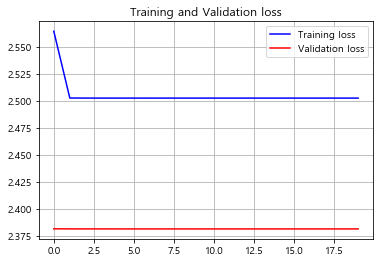

In [25]:
plot_train_history(single_step_history,'Training and Validation loss')

In [26]:
mpl.rcParams['figure.figsize'] = (10, 5)
plt.bar(x = range(len(data_minmax.columns)),
        height=lstm_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(data_minmax.columns)))
_ = axis.set_xticklabels(data_minmax.columns, rotation=90)

AttributeError: 'LSTM' object has no attribute 'kernel'

In [30]:
for x,y in val_data_single.take(1):
    print(x)
    print(y)
    print(lstm_model.predict(x))
    from sklearn.metrics import mean_squared_error
    testScore=math.sqrt(mean_squared_error(y,lstm_model.predict(x)))
    print('Train Score: %.2f RMSE'%(testScore))

tf.Tensor(
[[[0.02330137 0.356633   0.33296524 0.35123321 0.00588386 0.02760736
   0.02307647 0.00084425]
  [0.04582604 0.356633   0.33296524 0.35123321 0.04937324 0.21165644
   0.09110804 0.07240754]
  [0.04331347 0.356633   0.33296524 0.35123321 0.00306984 0.13496933
   0.10901131 0.03772161]
  [0.00885251 0.356633   0.33296524 0.35123321 0.00076746 0.05828221
   0.0237377  0.37268955]]], shape=(1, 4, 8), dtype=float64)
tf.Tensor([3.78912685], shape=(1,), dtype=float64)
[[1.]]
Train Score: 2.79 RMSE


In [31]:
for i in range(1,413,1):
    for x,y in val_data_single.take(i):
        sum=0
        count=0
        pred_y=lstm_model.predict(x)
        score=(y-pred_y)**2
        sum+=score
        count=count+1

In [32]:
squared_mean=sum/count
RMSE=math.sqrt(squared_mean)
print('Train Score: %.2f RMSE'%(RMSE))

Train Score: 1.00 RMSE
